# Pràctica 2: Neteja i anàlisi de dades

## 1. Dataset

El dataset emprat en aquesta pràctica és el generat a la PRA1 de l'assignatura, on vam recollir les dades de la web de Fotocasa dels pisos en lloguer a la ciutat de Barcelona (a data d'octubre de 2020), mitjançant scraping.

L'objectiu de l'anàlisi de les dades d'aquest dataset és:

- Respondre a la pregunta de si hi ha diferències significatives en els preus de lloguer entre els diferents barris de la ciutat.
- Respondre a la pregunta de si hi ha diferències significatives en els preus de lloguer entre les diferents agències.
- Crear un model de regressió que permeti predir el preu d'un habitatge en base a les seves característiques.
- Crear un model no supervisat que ens permeti identificar clústers d'observacions amb el preu inflat respecte al preu mitjà tèoric del seu barri, i plasmar aquests clústers a un mapa de coordenades (latitud, longitud), per tal de veure si es corresponen amb zones específiques de la ciutat.

## 2. Selecció de dades

Primerament, determinarem quines són les variables del nostre dataset i el seu tipus. Seguidament, eliminarem aquelles que no aportin informació útil de cara a la nostra anàlisi. Finalment, farem una eliminació de files duplicades.

In [1]:
import pandas as pd

apartments = pd.read_csv('../csv/data_initial.csv')

### Eliminació de dimensions

In [2]:
apartments.dtypes

id                       int64
address                 object
bathrooms                int64
building_subtype        object
building_type           object
conservation_state     float64
date                    object
discount                 int64
floor_elevator           int64
is_new_construction       bool
latitude               float64
link                    object
longitude              float64
price                  float64
realestate              object
realestate_id            int64
rooms                    int64
sqft_m2                  int64
neighbourhood           object
neighb_meanprice       float64
dtype: object

Donats els objectius de la nostra anàlisi, hi ha certes columnes del dataset que podem eliminar:

- __id__, que simplement conté l'índex de la fila dintre del dataset, de moment la deixem per si hem de sel·leccionar files per aquest índex.
- __address__, que conté la direcció del pis. Ja tenim el barri disponible a la columna __neighbourhood__ i per tant, aquest camp aporta informació innecessària a la nostra anàlisi.
- __date__, que conté la data en la que es va recollir la mostra. Solament la vam recollir un dia específic i per tant, no aporta cap informació rellevant a l'anàlisi actual.
- __realestate_id__, que conté l'identificador de l'agència que oferta el pis en lloguer. Ens preferim quedar amb el nom ja que ens permetrà visualitzar la informació de manera més clara

In [3]:
apartments = apartments.drop(columns=['address', 'date', 'realestate_id'])

### Eliminació de files duplicades

L'eliminació de files duplicades la portarem a terme en base a la variable __link__. Si tenim dues o més observacions del mateix pis de la web de Fotocasa, ens quedarem únicament amb la primera:

In [4]:
apartments.loc[apartments.duplicated('link')]

,id,bathrooms,building_subtype,building_type,conservation_state,discount,floor_elevator,is_new_construction,latitude,link,longitude,price,realestate,rooms,sqft_m2,neighbourhood,neighb_meanprice
39,39,1,Apartment,Flat,NaN,0,0,False,41.38071,/es/alquiler/vivienda/barcelona-capital/el-rav...,2.168707,525.0,INVERSIONES INMOBILIARIAS Y FINANCIERAS SANT A...,0,35,el raval,14.323614
40,40,1,Apartment,Flat,NaN,0,0,False,41.38071,/es/alquiler/vivienda/barcelona-capital/el-rav...,2.168707,525.0,INVERSIONES INMOBILIARIAS Y FINANCIERAS SANT A...,0,35,el raval,14.323614
41,41,1,Apartment,Flat,NaN,0,0,False,41.38071,/es/alquiler/vivienda/barcelona-capital/el-rav...,2.168707,525.0,INVERSIONES INMOBILIARIAS Y FINANCIERAS SANT A...,0,35,el raval,14.323614
42,42,1,Apartment,Flat,NaN,0,0,False,41.38071,/es/alquiler/vivienda/barcelona-capital/el-rav...,2.168707,525.0,INVERSIONES INMOBILIARIAS Y FINANCIERAS SANT A...,0,35,el raval,14.323614
43,43,1,Apartment,Flat,NaN,0,0,False,41.38071,/es/alquiler/vivienda/barcelona-capital/el-rav...,2.168707,525.0,INVERSIONES INMOBILIARIAS Y FINANCIERAS SANT A...,0,35,el raval,14.323614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11803,11803,2,Attic,Flat,1.0,200,1,False,41.39394,/es/alquiler/vivienda/barcelona-capital/aire-a...,2.121359,3700.0,Stipek Ferrer Premium Properties,4,280,sarrià,16.866645
11804,11804,2,Attic,Flat,1.0,200,1,False,41.39394,/es/alquiler/vivienda/barcelona-capital/aire-a...,2.121359,3700.0,Stipek Ferrer Premium Properties,4,280,sarrià,16.866645
12007,12007,5,Flat,Flat,2.0,0,1,False,41.39514,/es/alquiler/vivienda/barcelona-capital/aire-a...,2.141838,5300.0,Max Ricart,6,280,sant gervasi - galvany,15.275452
12061,12061,2,Apartment,Flat,NaN,594,0,False,41.39498,/es/alquiler/vivienda/barcelona-capital/aire-a...,2.147670,6073.0,Homelike,4,100,sant gervasi - galvany,15.275452


In [5]:
apartments = apartments.drop_duplicates('link')

### Tipus de dades

Si observem els tipus de dades anteriors, es pot veure com __conservation_state__, __building_subtype__ y __building_type__ poden ser variables categòriques, o com __floor_elevator__ és en realitat una variable booleana. Podem aplicar la conversió sobre aquestes variables amb l'objectiu de millorar l'anàlisi:

In [6]:
apartments = apartments.astype({
    'conservation_state': 'category',
    'building_subtype': 'category',
    'building_type': 'category',
    'floor_elevator': 'bool',
    'neighbourhood':'category'
})

## 3. Neteja de dades

### Valors buits

Anem a determinar quins són els valors buits de cadascuna de les columnes:

In [7]:
apartments.isna().sum()

id                        0
bathrooms                 0
building_subtype          0
building_type             0
conservation_state     5340
discount                  0
floor_elevator            0
is_new_construction       0
latitude                  0
link                      0
longitude                 0
price                     4
realestate              106
rooms                     0
sqft_m2                   0
neighbourhood             1
neighb_meanprice          1
dtype: int64

Veiem que molts habitatges no tenen informació sobre l'estat de conservació. Omplirem amb -1 aquells que no en tinguin:

In [8]:
apartments['conservation_state'] = apartments['conservation_state'].cat.add_categories(-1)

apartments['conservation_state'] = apartments['conservation_state'].fillna(-1)

Donat que volem respondre a la pregunta de si hi ha diferències de preu entre les diferents agències, eliminem les observacions que no tenen agència:

In [9]:
apartments = apartments.dropna(subset=['realestate'])
apartments.isna().sum()

id                     0
bathrooms              0
building_subtype       0
building_type          0
conservation_state     0
discount               0
floor_elevator         0
is_new_construction    0
latitude               0
link                   0
longitude              0
price                  4
realestate             0
rooms                  0
sqft_m2                0
neighbourhood          1
neighb_meanprice       1
dtype: int64

Pel que fa al preu, es tracta de poques observacions que tenen un valor buit per aquesta variable. Com que l'objectiu d'aquesta anàlisi gira entorn al preu, decidim inserir la informació de forma manual consultant la web de Fotocasa:

In [10]:
apartments[apartments.price.isna()]['link']

12154    /es/alquiler/vivienda/barcelona-capital/calefa...
12155    /es/alquiler/vivienda/barcelona-capital/ascens...
12156    /es/alquiler/vivienda/barcelona-capital/aire-a...
12157    /es/alquiler/vivienda/barcelona-capital/aire-a...
Name: link, dtype: object

Les quatre observacions, un cop consultat el link al web de Fotocasa, corresponen a habitatges que no tenen preu, indicant-ho al web com pre "a consultar". Com necessitem treballar amb els preus, procedirem a eliminiar aquestes dades.

In [11]:
apartments = apartments.dropna(subset=['price'])

Finalment, ens queda omplir manualment les observacions que no tenen barri, de nou, mitjançant l'enllaç de Fotocasa per veure si podem determinar aquesta informació:

In [12]:
apartments[apartments.neighbourhood.isna()]

,id,bathrooms,building_subtype,building_type,conservation_state,discount,floor_elevator,is_new_construction,latitude,link,longitude,price,realestate,rooms,sqft_m2,neighbourhood,neighb_meanprice
1384,1384,1,Flat,Flat,-1.0,0,False,False,41.35395,/es/alquiler/vivienda/barcelona-capital/la-mar...,2.148532,750.0,FINCAS LAFONT,3,70,NaN,NaN


Veiem que es correspon amb el barri de "La marina de Port", així que li assignem el preu mitjà d'aquest barri.

In [13]:
mean_price_marina = float(apartments[apartments['neighbourhood']=='la marina de port'].head(1)['neighb_meanprice'])

apartments.loc[apartments.id ==1384, 'neighbourhood'] = 'la marina de port'
apartments.loc[apartments.id ==1384, 'neighb_meanprice'] = mean_price_marina



Podem observar que ara el dataset no té valors buits:

In [14]:
apartments.isna().sum()

id                     0
bathrooms              0
building_subtype       0
building_type          0
conservation_state     0
discount               0
floor_elevator         0
is_new_construction    0
latitude               0
link                   0
longitude              0
price                  0
realestate             0
rooms                  0
sqft_m2                0
neighbourhood          0
neighb_meanprice       0
dtype: int64

Podem eliminar l'id:

In [15]:
apartments = apartments.drop(columns=['id'])

### Outliers

El que primer farem, serà visualitzar a gràfics de tipus boxplot cadascuna de les variables quantitatives per tal de determinar si tenim o no outliers:

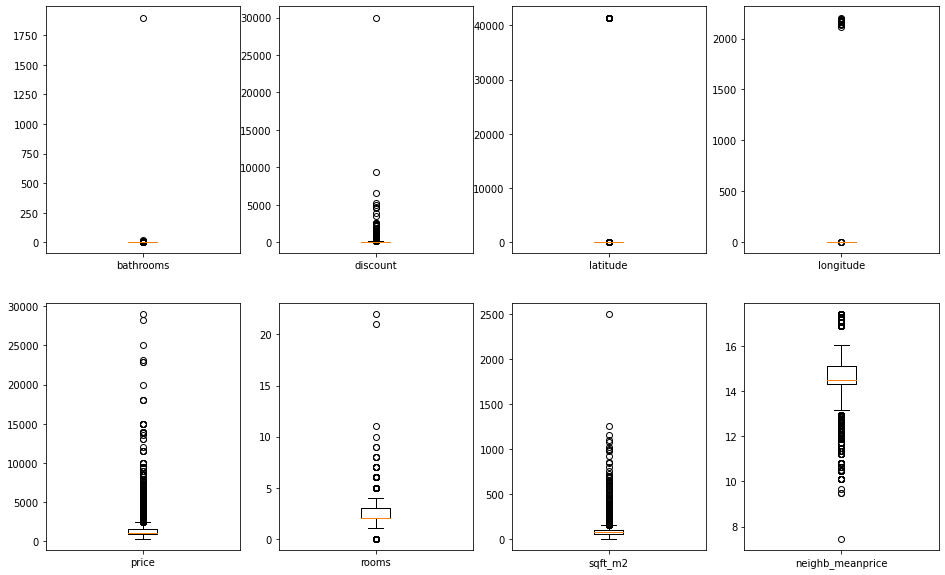

In [16]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import math

fig = plt.figure(figsize=(16,10))
numeric_attributes = apartments.select_dtypes(include=np.number).columns
for idx, column in enumerate(numeric_attributes):
    ax = fig.add_subplot(2, math.ceil(len(numeric_attributes)/2), idx+1)
    ax.boxplot(apartments[[column]], labels=[column])

Sembla evident que tenim prou valors extrems al dataset per a cadascuna de les variables quantitatives. El que cal és determinar si aquests valors són reals i per tant els hem de tenir en compte a l'anàlisi, o d'altra banda podem eliminar aquells que considerem outliers.

#### Price
Si seleccionam els 5 preus més alts del dataset, podem comprovar com es tracta de valors vàlids quan accedim al detall a la pàgina de Fotocasa:

In [17]:
apartments.sort_values('price', ascending=False).head()[['link', 'rooms', 'bathrooms', 'realestate', 'sqft_m2', 'price']]

,link,rooms,bathrooms,realestate,sqft_m2,price
12153,/es/alquiler/vivienda/barcelona-capital/aire-a...,4,4,VIP PISOS,600,29000.0
12152,/es/alquiler/vivienda/barcelona-capital/aire-a...,8,7,Homelike,550,28279.0
12151,/es/alquiler/vivienda/barcelona-capital/aire-a...,21,21,ENGEL & VOELKERS,2500,25000.0
12150,/es/alquiler/vivienda/barcelona-capital/aire-a...,3,2,Homelike,85,23092.0
12149,/es/alquiler/vivienda/barcelona-capital/aire-a...,2,1,Homelike,54,22839.0


Sembla per tant que existeixen uns pocs pisos al dataset amb preus molt elevants, i característiques com nombre d'habitacions, metres quadrats o nombre de banys amb valors que tot i semblar extrems, són vàlids. Per aquest motiu, decidim __mantenir__ aquestes observacions per tal de dur a terme l'anàlisi de dades.

#### Latitude i Longitude

Si s'examinen les variables latitude i longitude, hi veiem valors sospitosos. La latitud és un valor que oscil·la entre -90 i 90, mentre que la longitud ho fa entre -180 i 180. Per tant, qualsevol observació d'aquestes variables fora d'aquest rang es podria considerar un outlier. D'altra banda, esperem que tots els habitages es trobin a la ciutat de Barcelona, per tant, que tinguin coordenades molt semblants.

In [18]:
apartments[(apartments['latitude'] > 90) | (apartments['latitude'] < -90)].sort_values('latitude', ascending=False).head(100)[['link', 'latitude', 'longitude', 'neighbourhood', 'price']]

,link,latitude,longitude,neighbourhood,price
3979,/es/alquiler/vivienda/barcelona-capital/aire-a...,41436.0,2.173259,porta,950.0
4177,/es/alquiler/vivienda/barcelona-capital/aire-a...,41428.0,2.189229,la sagrera,955.0
1266,/es/alquiler/vivienda/barcelona-capital/ascens...,41424.0,2.151020,la teixonera,750.0
3694,/es/alquiler/vivienda/barcelona-capital/aire-a...,41422.0,2.188695,sant antoni,910.0
6027,/es/alquiler/vivienda/barcelona-capital/calefa...,41418.0,2.171966,el guinardó,1100.0
...,...,...,...,...,...
4181,/es/alquiler/vivienda/barcelona-capital/aire-a...,41373.0,2.157460,el poble sec - aei parc montjuïc,955.0
6920,/es/alquiler/vivienda/barcelona-capital/aire-a...,41372.0,2.138111,la bordeta,1200.0
7003,/es/alquiler/vivienda/barcelona-capital/aire-a...,41372.0,2.127435,sants,1200.0
2567,/es/alquiler/vivienda/barcelona-capital/aire-a...,41372.0,2.147444,la font de la guatlla,850.0


Pel que fa a __latitude__, sembla que existeix un error a l'hora d'interpretar els decimals. Les observacions que tenim pels pisos de Barcelona, tenen una latitud que oscil·la entre els següents valors:

In [19]:
apartments[(apartments['latitude']) < 90]['latitude'].max()

41.46262

In [20]:
apartments[(apartments['latitude']) < 90]['latitude'].min()

41.35395

Podem corregir fàcilment els valors incorrectes, ja que tots són superiors a 41370, dividint  el valor de __latitude__ entre 1000 per a aquestes observacions:

In [21]:
apartments.loc[apartments['latitude'] > 41370, 'latitude'] = apartments['latitude']/1000
apartments.sort_values('latitude', ascending=False).head(10)[['link', 'latitude', 'longitude', 'neighbourhood', 'price']]

,link,latitude,longitude,neighbourhood,price
228,/es/alquiler/vivienda/barcelona-capital/terraz...,41.46262,2.180195,ciutat meridiana,600.0
15,/es/alquiler/vivienda/barcelona-capital/terraz...,41.45524,2.174660,torre baró,490.0
609,/es/alquiler/vivienda/barcelona-capital/terraz...,41.45345,2.190106,la trinitat vella,675.0
978,/es/alquiler/vivienda/barcelona-capital/amuebl...,41.45231,2.191007,la trinitat vella,715.0
509,/es/alquiler/vivienda/barcelona-capital/aire-a...,41.45208,2.192924,la trinitat vella,650.0
578,/es/alquiler/vivienda/barcelona-capital/aire-a...,41.45131,2.190549,la trinitat vella,664.0
296,/es/alquiler/vivienda/barcelona-capital/terraz...,41.45129,2.189722,la trinitat vella,647.0
222,/es/alquiler/vivienda/barcelona-capital/terraz...,41.45118,2.189822,la trinitat vella,600.0
1344,/es/alquiler/vivienda/barcelona-capital/no-amu...,41.45047,2.191933,la trinitat vella,750.0
7797,/es/alquiler/vivienda/barcelona-capital/calefa...,41.44968,2.190399,la trinitat vella,1250.0


Podem aplicar el mateix procés per al camp __longitude__:

In [22]:
apartments[(apartments['longitude'] > 180) | (apartments['longitude'] < -180)].sort_values('longitude', ascending=False).head(100)[['link', 'latitude', 'longitude', 'neighbourhood', 'price']]

,link,latitude,longitude,neighbourhood,price
4023,/es/alquiler/vivienda/barcelona-capital/aire-a...,41.39861,2206.0,el poblenou,950.0
1430,/es/alquiler/vivienda/barcelona-capital/ascens...,41.41937,2188.0,navas,750.0
3229,/es/alquiler/vivienda/barcelona-capital/calefa...,41.38230,2188.0,la barceloneta,900.0
2042,/es/alquiler/vivienda/barcelona-capital/aire-a...,41.43369,2186.0,sant andreu,800.0
411,/es/alquiler/vivienda/barcelona-capital/sant-p...,41.38697,2177.0,"sant pere, santa caterina i la ribera",650.0
4265,/es/alquiler/vivienda/barcelona-capital/aire-a...,41.38697,2177.0,"sant pere, santa caterina i la ribera",975.0
5685,/es/alquiler/vivienda/barcelona-capital/calefa...,41.40808,2169.0,el baix guinardó,1090.0
5683,/es/alquiler/vivienda/barcelona-capital/calefa...,41.40816,2169.0,el baix guinardó,1090.0
2899,/es/alquiler/vivienda/barcelona-capital/ascens...,41.37688,2168.0,el raval,855.0
896,/es/alquiler/vivienda/barcelona-capital/can-ba...,41.41630,2164.0,can baró,700.0


Les observacions pels pisos de Barcelona tenen una longitud que oscil·la entre els següents valors:

In [23]:
apartments[(apartments['longitude']) < 180]['longitude'].max()

2.224126

In [24]:
apartments[(apartments['longitude']) < 180]['longitude'].min()

2.0915220000000003

De nou, si dividim els valors de __longitude__ superiors a 2110 entre 1000, corregirem els valors d'aquestes observacions:

In [25]:
apartments.loc[apartments['longitude'] > 2110, 'longitude'] = apartments['longitude']/1000
apartments.sort_values('longitude', ascending=False).head(10)[['link', 'latitude', 'longitude', 'neighbourhood', 'price']]

,link,latitude,longitude,neighbourhood,price
8502,/es/alquiler/vivienda/barcelona-capital/aire-a...,41.41129,2.224126,el besòs i el maresme,1350.0
10272,/es/alquiler/vivienda/barcelona-capital/aire-a...,41.41315,2.222797,el besòs i el maresme,1800.0
11252,/es/alquiler/vivienda/barcelona-capital/aire-a...,41.41155,2.221454,el besòs i el maresme,2600.0
10433,/es/alquiler/vivienda/barcelona-capital/aire-a...,41.41163,2.220950,el besòs i el maresme,1900.0
10232,/es/alquiler/vivienda/barcelona-capital/aire-a...,41.41353,2.220937,el besòs i el maresme,1800.0
9594,/es/alquiler/vivienda/barcelona-capital/aire-a...,41.41261,2.220891,el besòs i el maresme,1600.0
8157,/es/alquiler/vivienda/barcelona-capital/aire-a...,41.41361,2.220773,el besòs i el maresme,1300.0
11048,/es/alquiler/vivienda/barcelona-capital/calefa...,41.41253,2.220563,el besòs i el maresme,2400.0
8611,/es/alquiler/vivienda/barcelona-capital/aire-a...,41.40981,2.220171,diagonal mar i el front marítim del poblenou,1400.0
11098,/es/alquiler/vivienda/barcelona-capital/aire-a...,41.41261,2.220109,el besòs i el maresme,2500.0


#### Bathrooms

Per a aquest camp, tot i que hem comentat que hi ha valors alts que considerem vàlids, si observem el boxplot veiem que hi ha una observació que té un valor molt extrem:

In [26]:
apartments[apartments['bathrooms'] > 100][['link', 'bathrooms', 'rooms', 'sqft_m2', 'price']]


,link,bathrooms,rooms,sqft_m2,price
10875,/es/alquiler/vivienda/barcelona-capital/aire-a...,1901,3,135,2200.0


A la web de Fotocasa, s'indica també aquest valor. Tot i això, no és lògic tenir 1901 banys a un pis de 135 metres quadrats de 3 habitacions i per tant, decidim eliminar aquesta observació:

In [27]:
apartments = apartments.drop(index=10875)

In [28]:
apartments.bathrooms.max()

21

#### Superfície

In [29]:
apartments = apartments[apartments['sqft_m2'] != 0]

### Transformació de dades

Afegirem una nova variable que calculi la diferència de cada habitatge sobre el preu mig del barri:

In [30]:
apartments['diff_mitjana'] = ((apartments['price']/(apartments.neighb_meanprice*apartments.sqft_m2))-1)*100

### Fitxer csv amb les dades finals a analitzar

In [31]:
apartments.to_csv('../csv/data_clean.csv')

## 4. Anàlisi

### Grups a comparar

- Es vol comparar si hi ha diferències de preus estadísticament significatives entre els diferents barris. Cada barri serà, per tant, un grup diferent.
- Es vol comparar si hi ha diferències de preus estadísticament significatives entre les diferents agències. Cada agència serà, per tant, un grup diferent.

### Comprovació de la normalitat de la variable price

Atès que les anàlisi d'estadística inferencial que portarem a terme impliquen en tots els casos la variable __price__, serà necessari comprovar prèviament la normalitat d'aquesta variable per tal de saber si hem d'aplicar proves paramètriques o no paramètriques. 

Anem a visualitzar l'histograma i el gràfic Q-Q de la variable price per tenir una orientació visual de si aquesta variable segueix o no una distribució normal:

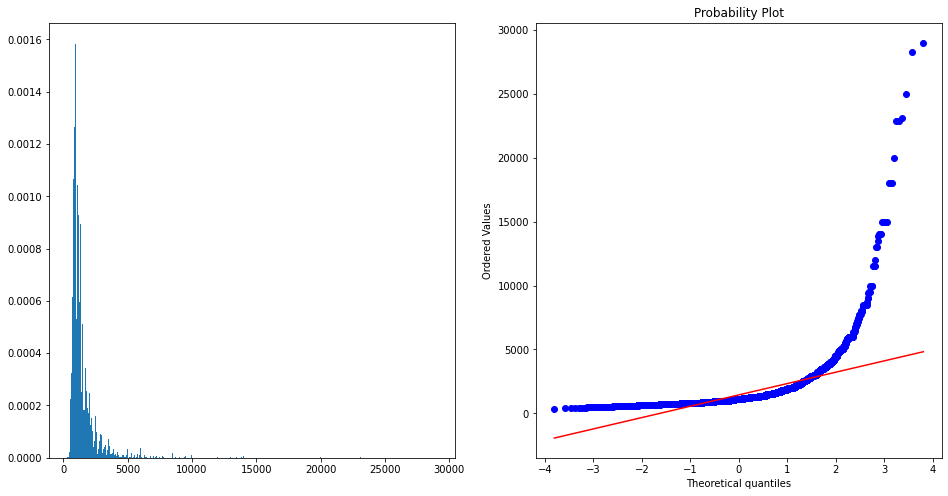

In [32]:
from scipy import stats

fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(1, 2, 1)
ax.hist(apartments.price, 500, density=True)

ax = fig.add_subplot(1, 2, 2)
stats.probplot(apartments.price, dist='norm', plot=plt)
pass

A simple vista, no sembla que la variable __price__ segueixi una distribució normal. Per tal de comprovar-ho, portarem a terme la prova de Kolmogorov-Smirnov. El motiu de portar a terme aquesta prova i no la de Shapiro-Wilk, és perquè amb la implementació de Scipy, per un nombre de mostres superior a 5000, el p-value pot no esser precís.

In [33]:
stats.kstest(apartments.price, 'norm', args=(apartments.price.mean(), apartments.price.std()))

KstestResult(statistic=0.2449490400964482, pvalue=0.0)

Podem veure que el p-value és 0 en el nostre cas, més petit que el valor de significació escollit: 0.05. Per tant podem rebutjar la hipòtesi nul·la i concloure que la variable __price no segueix una distribució normal__.

### Comprovació de l'homoscedasticitat de la variable price per als diferents grups

Per comprovar l'homoscedasticitat de la variable __price__ per als diferents grups que volem comparar, emprarem el test de Fligner-Killeen, ja que prèviament hem observat que aquesta variable no segueix una distribució normal.

#### Homoscedasticitat dels preus dels barris

In [34]:
neighbourhood_grouped_samples = apartments.groupby('neighbourhood')['price'].apply(pd.Series.tolist).tolist()
stats.fligner(*neighbourhood_grouped_samples)

FlignerResult(statistic=2104.733108385882, pvalue=0.0)

Donat el p-value és < 0.05 (el valor de significació escollit), podem concloure doncs que __price__ presenta variàncies estadísticament diferents entre els barris de Barcelona.

####  Homoscedasticitat dels preus de les agències

In [35]:
realestate_grouped_samples = apartments.groupby('realestate')['price'].apply(pd.Series.tolist).tolist()
stats.fligner(*realestate_grouped_samples)

FlignerResult(statistic=3493.643125045974, pvalue=1.0719141814502517e-260)

Donat que el p-value és < 0.05 (el valor de significació escollit), podem concloure que __price__ presenta variàncies estadísticament diferents entre les agències immoniliaries.

### Comprovació de mitjanes de la variable price per als diferents grups

Ja hem vist com la variable __price__ no segueix una distribució normal, i com per als grups que es volen analitzar, la variància de __price__ entre ells presenta diferències estadísticament significants. Donat tot això, haurem d'emprar proves no paramètriques, en concret el test de Kruskal-Wallis, per tal de saber si la mitjana entre els diferents grups (que són més de dos tant en el cas dels barris com en el cas de les agències) presenta diferències estadísticament significants.

#### Comparació de mitjanes de preus entre els diferents barris

In [36]:
stats.kruskal(*neighbourhood_grouped_samples)

KruskalResult(statistic=2637.6757596495586, pvalue=0.0)

Donat que el p-value és < 0.05 (el valor de significació escollit), podem concloure que hi ha difències de preu estadísticament significatives entre els barris de Barcelona.

#### Comparació de mitjanes de preus entre les diferents agències

In [37]:
stats.kruskal(*realestate_grouped_samples)

KruskalResult(statistic=4887.593854046478, pvalue=0.0)

Donat que el p-value és < 0.05 (el valor de significació escollit), podem concloure que hi ha diferències de preu estadísticament significatives entre les ofertes de les diferents agències.

### Model de regressió

Anem a construïr un mode de regressió lineal que ens permeti fer prediccions sobre el preu dels habitatges. Per fer això, primer haure de fer unes tranformacions a les dades per que siguin manejables.

#### Codificació de les variables quantitatives
En un model de regressió no podem treballar directament amb dades categóriques. Hem de codificar-les per poder-les incloure en el nostre model. Optarem per One-Hot-Encoding, que ens permet introduïr variables dummy per cada una de les categòries d'una variable.


In [38]:
apartments.realestate.value_counts()

ENGEL & VOELKERS                                 836
Homelike                                         760
APROPERTIES REAL ESTATE Nº Aicat 6388            481
SH BARCELONA                                     381
AREA CASA                                        332
                                                ... 
SELLARES GESTIO DE PATRIMONIS IMMOBILIARIS SL      1
JAMES & ASSOCIATES DESIGN COMPANY SL               1
FINCAS ASENSIO                                     1
LOFTSANTFELIU                                      1
ISABEL PRIU                                        1
Name: realestate, Length: 1046, dtype: int64

Veiem que per la variable realestate tenim moltes categóries. Per reduir-ne el número, les classificarem segons el nombre d'habitatges que posen en lloguer. Anem a veure com es distribuexi la quantitat d'habitatges que té cada immobiliària.

In [39]:
counts_realestate = apartments.realestate.value_counts().to_frame().reset_index()
counts_realestate.columns = ['realestate', 'counts']

counts_realestate.describe()

,counts
count,1046.000000
mean,9.334608
std,42.954420
min,1.000000
25%,1.000000
50%,3.000000
75%,7.000000
max,836.000000


<AxesSubplot:>

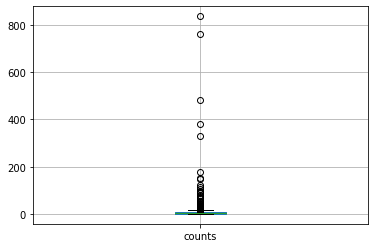

In [40]:
counts_realestate.boxplot()

Explorant les dades hem vist que TECNOCASA apareix disgregada en diferents oficines. Comencem per assignar-li la mateixa immobiliària

In [41]:
counts_realestate[counts_realestate.realestate.astype(str).str.contains('TECNOCASA')]

,realestate,counts
60,TECNOCASA RIERA ALTA MAR,24
120,TECNOCASA - ESTUDI AVINGUDA DE ROMA,13
193,TECNOCASA,9
370,TECNOCASA-ESTUDI GRAN DE SANT ANDREU,4
411,TECNOCASA - ESTUDI MARINA 311,4
466,TECNOCASA AVDA. MISTRAL,3
480,TECNOCASA - HOME GUINARDO,3
515,TECNOCASA - PISOS BORNE MAR,3
532,TECNOCASA - PROJECTE LA PROSPERITAT,3
564,TECNOCASA - ESTUDI PROJECTE SANT ANDREU,2


In [42]:
apartments.loc[apartments.realestate.astype(str).str.contains('TECNOCASA'),'realestate'] = 'TECNOCASA'
counts_realestate = apartments.realestate.value_counts().to_frame().reset_index()
counts_realestate.columns = ['realestate', 'counts']

Farem la suposició on tots aquells valors de realstate que només tinguin un habitatge els etiquetarem com a porpietaris particulars.

In [43]:
particulars = counts_realestate[counts_realestate.counts==1].realestate
apartments.loc[apartments.realestate.isin(particulars),"realestate_size"] = 'Particular'

Entre 2 i 10, els classificarem com a petits propietaris.

In [44]:
petits_propietaris = counts_realestate[np.logical_and(counts_realestate.counts>1, counts_realestate.counts<=10)].realestate
apartments.loc[apartments.realestate.isin(petits_propietaris),"realestate_size"] = 'Petit'

Entre 11 i 50 els classificarem com a propietaris mitjans.

In [45]:
mitja = counts_realestate[np.logical_and(counts_realestate.counts>10, counts_realestate.counts<=50)].realestate
apartments.loc[apartments.realestate.isin(mitja),"realestate_size"] = 'Mitja'

Més de 50 i menys de 300 com a grans propietaris

In [46]:
grans = counts_realestate[np.logical_and(counts_realestate.counts>50, counts_realestate.counts<=300)].realestate
apartments.loc[apartments.realestate.isin(grans),"realestate_size"] = 'Grans'

Més de 300, com a molt grans proietaris.

In [47]:
molt_grans = counts_realestate[counts_realestate.counts>300].realestate
apartments.loc[apartments.realestate.isin(molt_grans),"realestate_size"] = 'Molt grans'

Hem simplificat notablement la informació sobre les immobiliàries.

In [48]:
apartments.realestate_size.astype('category')
apartments.realestate_size.value_counts()


Molt grans    2790
Mitja         2619
Petit         2276
Grans         1721
Particular     358
Name: realestate_size, dtype: int64

Ara codifiquem les variables:

In [49]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

apartments_regression = apartments.drop(columns=['realestate','building_type','link','neighb_meanprice','diff_mitjana'])
cat_labels = apartments_regression.select_dtypes(include=['object', 'category','bool']).columns.to_list()
numeric_labels = apartments_regression.select_dtypes(include=['float64', 'int']).columns.to_list()

preprocessor = ColumnTransformer([('encoder', OneHotEncoder(), cat_labels)],
                    remainder='passthrough'
               )
apartments_regression_cod = preprocessor.fit_transform(apartments_regression)
cat_labels_encoded = preprocessor.named_transformers_['encoder'].get_feature_names(cat_labels)
new_labels = np.concatenate([cat_labels_encoded,numeric_labels])

apartments_regression_cod = pd.DataFrame(apartments_regression_cod.todense(), columns=new_labels)
apartments_regression_cod

,building_subtype_Apartment,building_subtype_Attic,building_subtype_CountryHouse,building_subtype_Duplex,building_subtype_Flat,building_subtype_GroundFloorWithGarden,building_subtype_House_Chalet,building_subtype_Loft,building_subtype_SemiDetached,building_subtype_SemidetachedHouse,...,realestate_size_Molt grans,realestate_size_Particular,realestate_size_Petit,bathrooms,discount,latitude,longitude,price,rooms,sqft_m2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,41.37723,2.160380,320.0,0.0,15.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,41.43157,2.169108,400.0,2.0,63.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,41.37141,2.144235,430.0,0.0,17.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,2.0,0.0,41.36364,2.139371,450.0,1.0,29.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,41.38046,2.160540,450.0,0.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9759,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,41.37645,2.142625,22839.0,2.0,54.0
9760,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,2.0,0.0,41.38043,2.152265,23092.0,3.0,85.0
9761,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,21.0,30000.0,41.42890,2.167005,25000.0,21.0,2500.0
9762,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,7.0,0.0,41.42745,2.167871,28279.0,8.0,550.0


In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from statsmodels.api import OLS
import statsmodels.api as sm

X = apartments_regression_cod.drop(columns = 'price')
y = apartments_regression_cod['price']
reg = OLS(y,X).fit()

reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     154.6
Date:                Wed, 23 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:42:10   Log-Likelihood:                -79351.
No. Observations:                9764   AIC:                         1.589e+05
Df Residuals:                    9671   BIC:                         1.596e+05
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
building_subtype_Apartment                                  4211.8233   5729.218      0.735      0.462   -7018.643    1.54e+04
building_subtype_Attic                                      4117.7463   5729.957      0.719      0.472   -7114.168    1.53e+04
building_subtype_CountryHouse                              -1.604e+04   5912.692     -2.713      0.007   -2.76e+04   -4450.380
building_subtype_Duplex                                     3822.2003   5731.142      0.667      0.505   -7412.038    1.51e+04
building_subtype_Flat                                       3788.4442   5730.031      0.661      0.509   -7443.617     1.5e+04
building_subtype_GroundFloorWithGarden                      3884.5898   5726.958      0.678      0.498   -7341.446    1.51e+04
building_subtype_House_Chalet                               4368.3338   5737.173      0.761      0.446   -6877.726    1.56e+04
building_subtype_Loft                                       3989.0087   5728.314      0.696      0.486   -7239.687    1.52e+04
building_subtype_SemiDetached                               4825.7286   5742.887      0.840      0.401   -6431.531    1.61e+04
building_subtype_SemidetachedHouse                          3256.8293   5737.739      0.568      0.570   -7990.340    1.45e+04
building_subtype_Study                                      3812.6296   5730.310      0.665      0.506   -7419.977     1.5e+04
conservation_state_-1.0                                     4066.8750   1.05e+04      0.387      0.699   -1.65e+04    2.47e+04
conservation_state_1.0                                      4099.3003   1.05e+04      0.390      0.696   -1.65e+04    2.47e+04
conservation_state_2.0                                      4055.9893   1.05e+04      0.386      0.699   -1.65e+04    2.47e+04
conservation_state_3.0                                      4016.3879   1.05e+04      0.382      0.702   -1.66e+04    2.46e+04
conservation_state_4.0                                      3716.2390   1.05e+04      0.353      0.724   -1.69e+04    2.43e+04
conservation_state_8.0                                      4082.0489   1.05e+04      0.388      0.698   -1.65e+04    2.47e+04
floor_elevator_False                                        1.204e+04   3.15e+04      0.382      0.703   -4.97e+04    7.38e+04
floor_elevator_True                                           1.2e+04   3.15e+04      0.381      0.703   -4.98e+04    7.38e+04
is_new_construction_False                                   1.135e+04   3.15e+04      0.360      0.719   -5.04e+04    7.31e+04
is_new_construction_True                                    1.269e+04   3.15e+04      0.402      0.687   -4.91e+04    7.45e+04
neighbourhood_can baró             

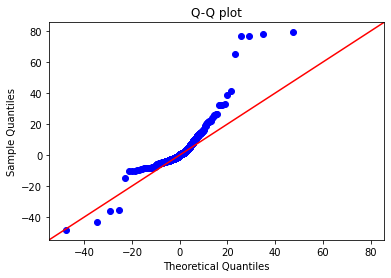

In [51]:
import scipy.stats as stats
res = reg.resid # residuals
fig = sm.qqplot(res, stats.t, fit=True, line="45")

plt.title('Q-Q plot')
plt.show()



Veiem que el model de regressió lineal no ens dona una capacitat predictiva gaire elevada, amb un R² proper al 0,6. Al resum del model, observem que moltes de les variables categòriques codificades no són especialment rellevants estadísticament. S'ha de mencionar, que el model de regressió lineal està enfocat a variables continues que originin una resposta lineal, així que no es sorprenen aquests resultats.
Al Q-Q plot veiem que no es compleixen les condicions d'homoscedasticitat, fet que podriem imaginar després de l'anàlisi de la variable price.

A continuació, provarem amb un model no lineal.

### Regessió amb arbre

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import seaborn as sb; 
from sklearn.ensemble import RandomForestClassifier



X = apartments_regression_cod.drop(columns = 'price')
y = apartments_regression_cod['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model = GradientBoostingRegressor( max_depth=3, min_samples_split=20)

model.fit(X_train, y_train)

GradientBoostingRegressor(min_samples_split=20)

In [53]:
accuracy = model.score(X_test, y_test)

print("El model té una precisió pel conjunt de test de: "+str(round(accuracy*100,2))+"%")

El model té una precisió pel conjunt de test de: 66.19%


Sembla que aquest model millora la capacitat predictiva de la regressió lineal. La capacitat de treballar amb atributs categòrics i numèrics i la natura geomètrica del algoritme, són punts a favor d'aquest model que es traslladen en una millor predicció.

### Classificació sobre preu inflat

Anem a construïr un altre model, en aquest cas no per predir el preu, sinó per saber si aquest està inflat respecte a la mitjana del barri o no.

In [54]:
apartments_classification = apartments.drop(columns=['realestate','building_type','link','neighb_meanprice'])
cat_labels = apartments_classification.select_dtypes(include=['object', 'category','bool']).columns.to_list()
numeric_labels = apartments_classification.select_dtypes(include=['float64', 'int']).columns.to_list()

preprocessor = ColumnTransformer([('encoder', OneHotEncoder(), cat_labels)],
                    remainder='passthrough'
               )
apartments_classification = preprocessor.fit_transform(apartments_classification)
cat_labels_encoded = preprocessor.named_transformers_['encoder'].get_feature_names(cat_labels)
new_labels = np.concatenate([cat_labels_encoded,numeric_labels])

apartments_classification = pd.DataFrame(apartments_classification.todense(), columns=new_labels)
apartments_classification['inflat'] = apartments_classification['diff_mitjana'] > 0
apartments_classification = apartments_classification.drop(columns=['diff_mitjana'])

In [55]:
from sklearn.metrics import accuracy_score

X = apartments_classification.drop(columns = 'inflat')
y = apartments_classification['inflat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

rf_tree = RandomForestClassifier(n_estimators=6, max_depth=10)

rf_tree.fit(X_train, y_train)

##CV

accuracy_cv_rf = cross_val_score(rf_tree, X_train, y_train)
print("El model té una precisió de validació creudada: "+str(round(np.mean(accuracy_cv_rf)*100,2))+"%")

### Precisió conjunt de test

y_pred = rf_tree.predict(X = X_test)
accuracy_rd = accuracy_score(y_test, y_pred)
print("El model té una precisió pel conjunt de test de: "+str(round(accuracy_rd*100,2))+"%")

El model té una precisió de validació creudada: 78.61%
El model té una precisió pel conjunt de test de: 80.11%


Obtenim bons resultats per aquest classificador, tant en el conjunt de test com el de validació creuada.

### Detecció de zones tensionades

A continuació, aprofitem que tenim les dades geogràfiques per veure si en podem treure alguna conclusió.

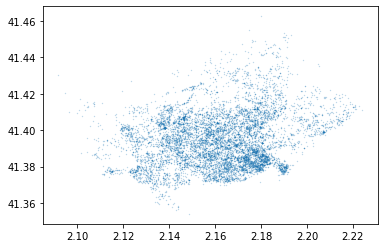

In [56]:
plt.scatter(apartments.longitude,apartments.latitude, s=0.1, alpha=0.4, cmap='viridis')


Ralitzarem un agrupament segons la diferència sobre la mitjana i la posició i visualitzarem el resultat amb les coordenades espacials, per veure si observem algún patró.

Utilitzarem DBSCAN ja que ens permet detecció d'outliers i és sensible a estructures per densitat. L'objectiu de l'agrupament és trobar punts calents a la ciutat on el preu estigui inflat. Per això, treballarem només amb les dades que tinguin el preu per sobre la mitjana, agruparem segons la posició, i balancejarem els punts segons la diferència sobre la mitjana.

Per començar, fem un estudi de quin és el nombre òptim de clusters:

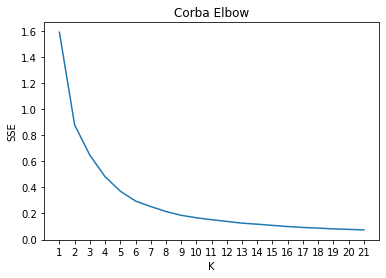

In [57]:
from sklearn import cluster      
from sklearn.preprocessing import scale

apartments_cl = apartments[apartments['diff_mitjana'] > 0].copy()
apartments_cl['diff_mitjana_positive'] = (apartments_cl['price']/(apartments_cl['neighb_meanprice']*apartments_cl['sqft_m2']))-1
points = apartments_cl[["longitude", "latitude"]].values
X = apartments_cl[['longitude','latitude']].values

Nc = range(1, 22)
kmeans = [cluster.KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X,sample_weight=apartments_cl.diff_mitjana_positive).inertia_ for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('Corba Elbow')
plt.xticks(Nc)
plt.show()

Text(0.5, 1.0, 'Agrupament per posició i diferència respecte a la mitjana')

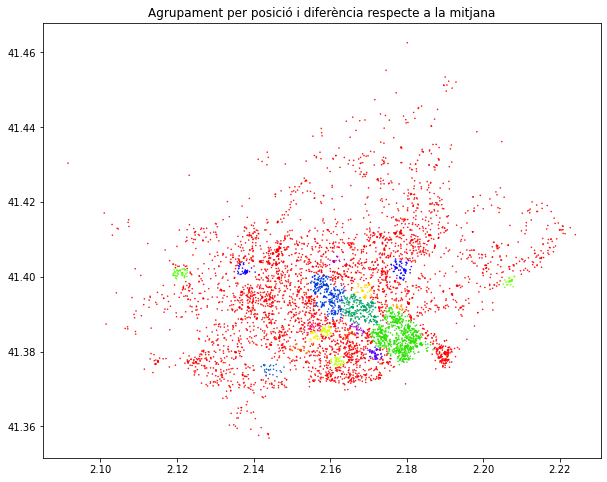

In [58]:
from sklearn import cluster 
from sklearn.preprocessing import scale
clustering = cluster.DBSCAN(eps=0.0015, min_samples=18).fit(X,sample_weight=apartments_cl['diff_mitjana_positive'])

y_kmeans = clustering.fit_predict(X,sample_weight=apartments_cl['diff_mitjana_positive'])
plt.figure(figsize=(10, 8))

apartments_cl['clusters'] = y_kmeans

plt.scatter(points[:, 0], points[:, 1], c=y_kmeans,alpha=1, s=0.3, cmap='prism')
plt.title("Agrupament per posició i diferència respecte a la mitjana")

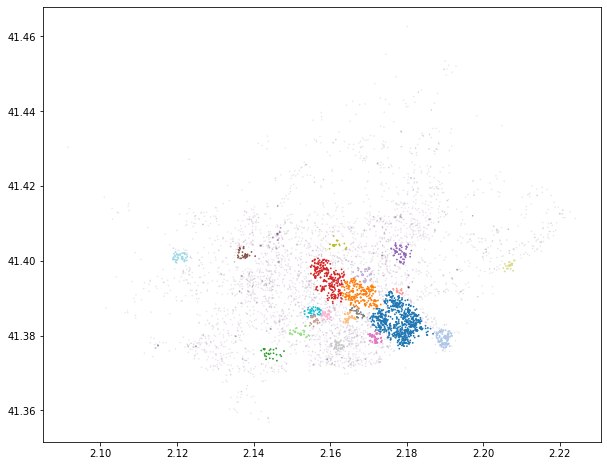

In [59]:
fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(111)
apartments_nclustered = apartments_cl[apartments_cl['clusters'] == -1]
ax1.scatter(apartments_nclustered.longitude, apartments_nclustered.latitude, c=apartments_nclustered.clusters,alpha=0.1, s=0.3)

apartments_clustered = apartments_cl[apartments_cl['clusters'] != -1]
ax1.scatter(apartments_clustered.longitude, apartments_clustered.latitude, c=apartments_clustered.clusters,alpha=1, s=0.6, cmap='tab20')


L'algorisme DBSCAN ens permet detectar outliers, que en aquest cas són elements que no s'han pogut relacionar amb cap clúster. Al segón gràfic els veiem en un color claret, mentre que els clústers en un color més fort i definit. Sembla que l'agrupament resultant respón a zones turístiques de la ciutat, que acostumen a ser zones tensionades.

## 5. Conclusions

Després de portar a terme l'anàlisi de les dades, podem presentar amb confiança les respostes als diferents objectius plantejats:

- Podem confirmar que existeixen diferències estadísticament significants entre els preus de lloguer dels diferents barris de la ciutat de Barcelona. Sembla un fet lògic, ja que a la majoria de ciutats existeixen barris on el preu és elevat, mentre que d'altres tenen preus mes moderats (zones menys turístiques) o fins i tot preus sorprenentment baixos (zones conflictives).

<AxesSubplot:title={'center':'Preus mitjans per barri'}, xlabel='Preu mitjà', ylabel='neighbourhood'>

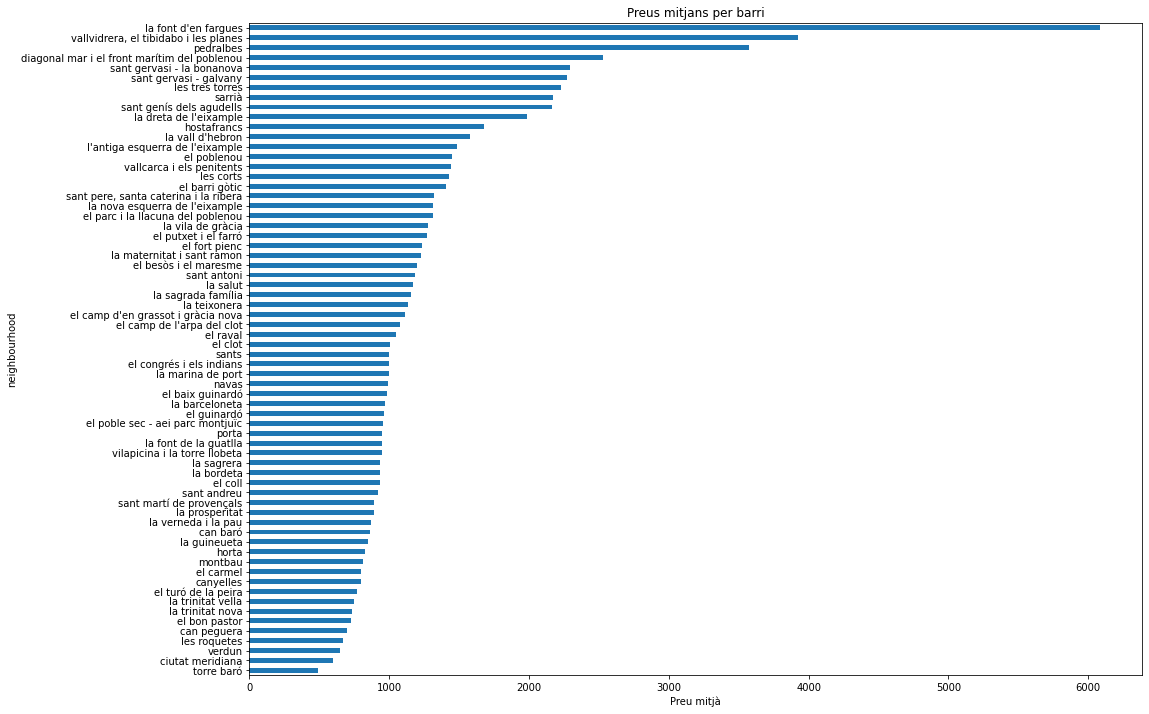

In [60]:
neighbourhood_mean_prices = apartments[['neighbourhood', 'price']].groupby('neighbourhood')['price'].mean().sort_values()
fig = plt.figure(figsize=(16,12))
plt.xlabel('Preu mitjà')
neighbourhood_mean_prices.plot.barh(title='Preus mitjans per barri')

- Podem confirmar també que existeixen diferències estadísticament significants entre els preus de lloguer que ofereixen les diferents agències a la ciutat de Barcelona. Podem explicar aquestes diferències degut a que sovint grans immobiliàries tenen una gran quota de mercat, especialment de pisos amb preus elevats, respecte a d'altres més petites i els particulars, per tant estan en una posició en la que poden jugar amb els preus més lliurement. En part podem observar aquest fet visualment si mirem els preus mitjans segons el tamany d'agència:

<AxesSubplot:title={'center':"Preus mitjans per tamany d'agència"}, xlabel='Preu mitjà', ylabel='realestate_size'>

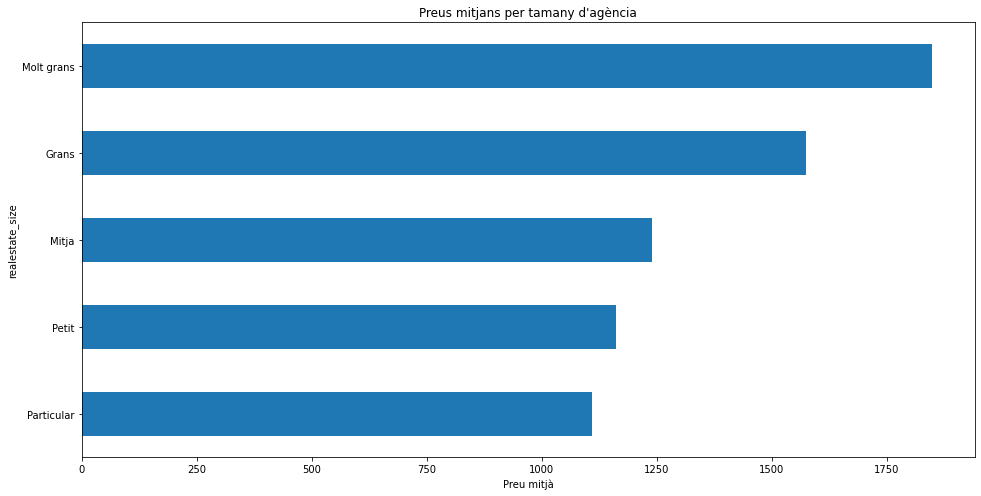

In [61]:
realestate_size_mean_price = apartments[['realestate_size', 'price']].groupby('realestate_size')['price'].mean().sort_values()
fig = plt.figure(figsize=(16, 8))
plt.xlabel('Preu mitjà')
realestate_size_mean_price.plot.barh(title="Preus mitjans per tamany d'agència")

- Es poden construir __models de regressió__ per intentar predir el preu de lloguer d'un habitatge. Tot i això, els models resultants que hem construit a aquesta pràctica (regressió lineal i regressió amb arbre) tenen una __precissió per sota del 70%__ en ambdós casos. Com a alternativa, podriem estudiar l'efecte dels valors extrems i proporcionar un model més precís per un rang de preus més acotat.

- El model de classificació no supervisat que hem creat mitjançant l'algorisme DBSCAN (a priori no coneixem el nombre de clústers que podríem formar), ens ha permès confirmar que hi ha zones específiques de la ciutat on el preu està molt per sobre del preu mitjà que aporten els organismes oficials. Com s'ha comentat, sembla que correspon amb zones turístiques, per tant no sorprenen aquests resultats. Tot i això, existeix la __possibilitat que els organismes oficials emprin un altre criteri per determinar els preus mitjans dels barris__, ja que a la majoria d'ells el preu mitjà de les observacions està per sobre del preu mitjà proporcionat pels organismes oficials:

<AxesSubplot:title={'center':'Diferència de preu per barri respecte mitjana oficial'}, xlabel='Diferència de preu (%)', ylabel='neighbourhood'>

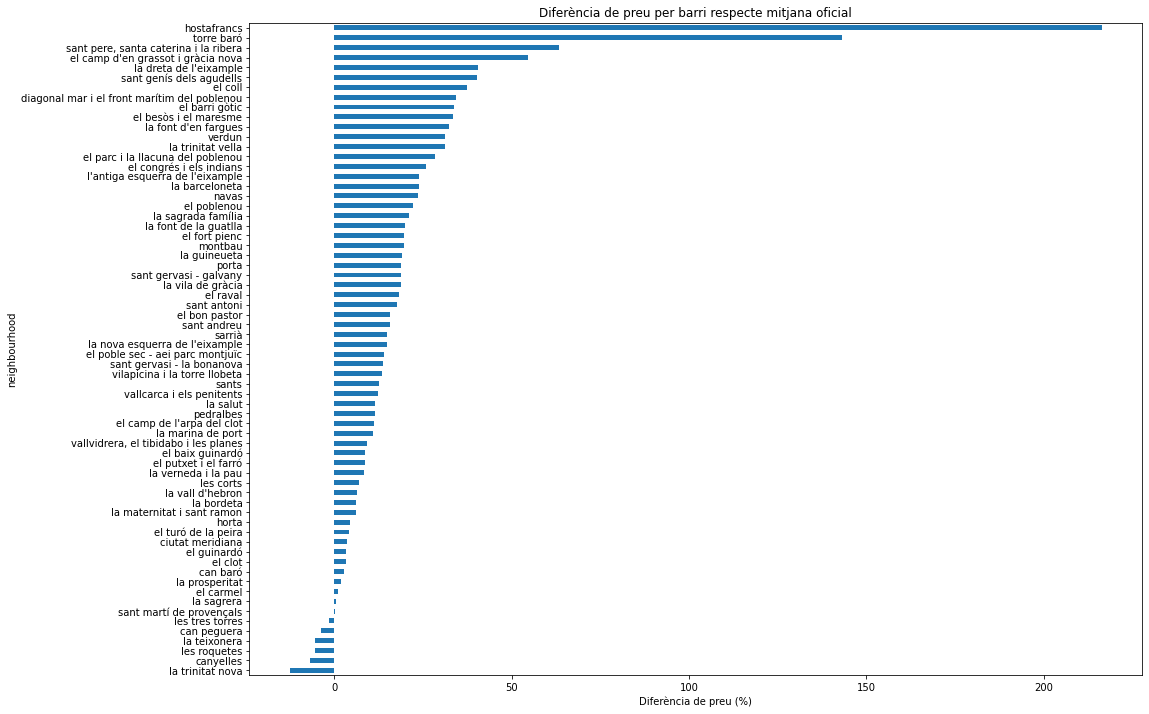

In [62]:
overpriced_neighbourhoods = apartments.groupby('neighbourhood', observed=True)['diff_mitjana'].mean().sort_values()
fig = plt.figure(figsize=(16, 12))
plt.xlabel('Diferència de preu (%)')
overpriced_neighbourhoods.plot.barh(title='Diferència de preu per barri respecte mitjana oficial')

## Taula de contribucions

<table>    
    <tr>
        <th>Contribucions</th>
        <th>Firma</th>
    </tr>
    <tr>
        <th>Investigació prèvia</th>
        <th>JOB, PBL</th>
    </tr>
    <tr>
        <th>Redacció de les respostes</th>
        <th>JOB, PBL</th>
    </tr>    
    <tr>
        <th>Desenvolupament codi</th>
        <th>JOB, PBL</th>
    </tr>    
</table>
